Adam Peetz, Regis Jesuit University 2023  

 
 

  

  

 
 

# Classifying cars and tanks: Transfer learning with Tensorflow and Keras  

 
 

  

 ## Tensors 

 
 

A tensor is a multidimensional array. A jpeg image is an example of a 3-dimensional tensor. It contains 3 layers of values for the colors red, green, and blue. When combined, these three color values create familiar 2-dimensional images. <br>  

 
 

  

 ## Tensorflow and Keras 

 
 

TensorFlow is a library from Google created by Abadi et. al. in 2015. It is designed to make mathematical operations on tensors easy. The mathematical operations inside a neural network usually rely on the manipulation of a series of tensors. Because of this, TensorFlow is most often used in deep learning applications. Tensorflow has a high-level API called Keras; created by Francois Chollet in 2015. Keras is designed to make interacting with Tensorflow straightforward and easy. <br>  

 
 

  

 ## Convolutional Neural Networks 

 
 

Convolutional Neural Networks (CNNs) slide a filter tensor over an image tensor to generate randomized patterns. When convolutional filters are stacked on top of each other the patterns become increasingly complex. At low levels, the patterns often resemble edges or shapes. At higher levels they become abstract, and sometimes begin to resemble distinct features in an image like eyes or beaks. Pathways inside the neural network that create useful patterns for a recognition task are reinforced during the training stage of a neural network. The pattern detecting power of a CNN allows an image to be fed into a network and a prediction to come out the other side. <br>  

 
 

Convolutional neural networks are one of the leading technologies for computer vision tasks. They can be employed to solve almost any image classification problems. Tensorflow and Keras will be used to create a transfer learning network for the classification of images of tanks and cars.<br>  

 
 

## Transfer Learning 

 
 

Transfer learning is one of the most powerful techniques in deep learning. Transfer learning takes the pretrained weights of an existing model and applies them to a new classification problem. It lets network designers use the resources and pattern recognition of a large professional models such as Xception for their own unique tasks.<br> 

 
 

The Xception network is known for its extensive use of depth wise convolutions. Xception detects cross channel correlations separate from spacial correlations to achieve outstanding accuracy on the ImageNet classification test. The Xception network will be used for transfer learning in this notebook. 

 
 

# Data Source 

 
 

Image classification tasks require a large library of labeled image files for training. The data used in this notebook was sourced from image specific subreddits; r/tankporn, r/carporn, and r/tanks. <br> 

 

In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageChops
from IPython.display import display 


from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import backend
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation, BatchNormalization 
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications import  Xception
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

import os, shutil 
from google.colab import drive 
np.random.seed(42)

# Connect to the Datasource 

 
 

Images used in the model are divided between classes and between training and test sets in a file directory. The directory structure allows Keras to stream a feed of images into the model from the class training directories while a portion is reserved for model testing. The class labels are inferred from the directory structure.  

 
 

Google drive is used to host the images used in this project. This code was derived from Regis's deep learning curriculum. 

In [2]:
#step 1, mount google drive (will require permission to login to your google account)
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#step 2, specify the base directory where images are located.  You need to save your data here.
base_dir = '/content/gdrive/My Drive/cars_tanks/'

In [4]:
#step 3, specify the training, validation, and test directories.  
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [5]:
#step 4, specify class directory structure
train_cars_dir = os.path.join(train_dir, 'cars')
train_tanks_dir = os.path.join(train_dir, 'tanks')

test_cars_dir = os.path.join(test_dir, 'cars')
test_tanks_dir = os.path.join(test_dir, 'tanks')

In [6]:
#step 5, print total number of files in each directory, tests connection was made to files
print(len(os.listdir(train_cars_dir)))
print(len(os.listdir(train_tanks_dir)))
print(len(os.listdir(test_cars_dir)))
print(len(os.listdir(test_tanks_dir)))

735
568
100
100


# Correct for Class Imbalance

There are 735 images of cars in the training dataset, and 568 images of tanks. This class imbalance presents a challenge for the model's development. During training the model will be shown more features that correlate to cars and be rewarded for developing pathways that predict for those features. This class imbalance would generate a model that favors prediction of cars at the expense of prediction for tanks. The imbalance can be corrected during training by increasing the importance of prediction for each class in proportion to its weight. 

 
 

Code to account for class weight was inspired by the TensorFlow documentation. 



In [7]:
# calculate class weight for each class
# important note, keras assigns classes in alphanumberic order
class_0_weight = (1 / len(os.listdir(train_cars_dir))) * (len(train_cars_dir)+len(os.listdir(train_tanks_dir)) / 2.0)
class_1_weight = (1 / len(os.listdir(train_tanks_dir))) * (len(train_cars_dir)+len(os.listdir(train_tanks_dir)) / 2.0)

class_weights = {0: class_0_weight, 1: class_1_weight}

print('Weight for class 0: {:.2f}'.format(class_0_weight))
print('Weight for class 1: {:.2f}'.format(class_1_weight)) 

Weight for class 0: 0.45
Weight for class 1: 0.58


# Exploratory Data Analysis

Random images can be drawn from each directory to display a sample of each class. This code was sourced from an example by Karinka Kapour (2021).

Sample a random image from each directory
/content/gdrive/My Drive/cars_tanks/train/cars/213.jpg


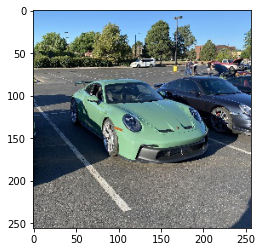

/content/gdrive/My Drive/cars_tanks/train/tanks/63.jpg


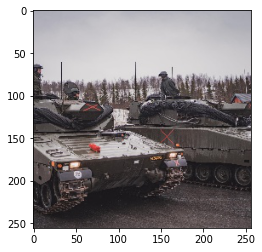

In [8]:
#step 1, create directory address for random image
cars_address = train_cars_dir+'/'+random.choice(os.listdir(train_cars_dir))
tanks_address = train_tanks_dir+'/'+random.choice(os.listdir(train_tanks_dir))
display_set = [cars_address, tanks_address]

#step 2, display random images
print("Sample a random image from each directory")
for display in display_set: 
    print(display)
    img = image.load_img(display)
    plt.figure()
    plt.imshow(img)
    plt.show() 

# Data Augmentation 

 
 

There are 1,303 images in the training dataset. This is a small dataset when compared to those used in competitions like ImageNet. The ImageNet dataset contains over a million images. Image classification models are known to benefit from large datasets. The number of images used for training can be expanded beyond the original 1,303 with data augmentation. <br> 

 
 

Augmenting images creates small adjustments to each image. Examples are adjusting the brightness of an image or flipping it horizontally or vertically. The best way to illustrate why this works is with an example. If the network has only seen images of cars taken in bright light it may assume the brightness of an image is a defining feature of a car. Adjusting the brightness of images as part of the augmentation pipeline will expand the dataset and help the model identify images with varying brightness. <br>

The effects of the augementation can bee seen below.

 

In [9]:
#step 1, creata augmentation image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.2,
#    zoom_range=0.2,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
#    vertical_flip=True,
    validation_split=0.2,
    fill_mode='nearest')

#step 2, combine image data generator and flow_from_directory to setup image stream
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical',
    subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical')

# step 3, generate batch size for training, validation, and test
training_step_size = len(train_generator)
validation_step_size = len(validation_generator)
test_step_size = len(test_generator)

Found 1043 images belonging to 2 classes.
Found 260 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [10]:
#step 1, pull out training images and labels from generator
sample_training_images, labels = next(train_generator)

In [11]:
#step 2, define plotimages function
def plotImages(images_arr,title):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax, titl in zip( images_arr, axes, title):
        ax.set_title(titl)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.8/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


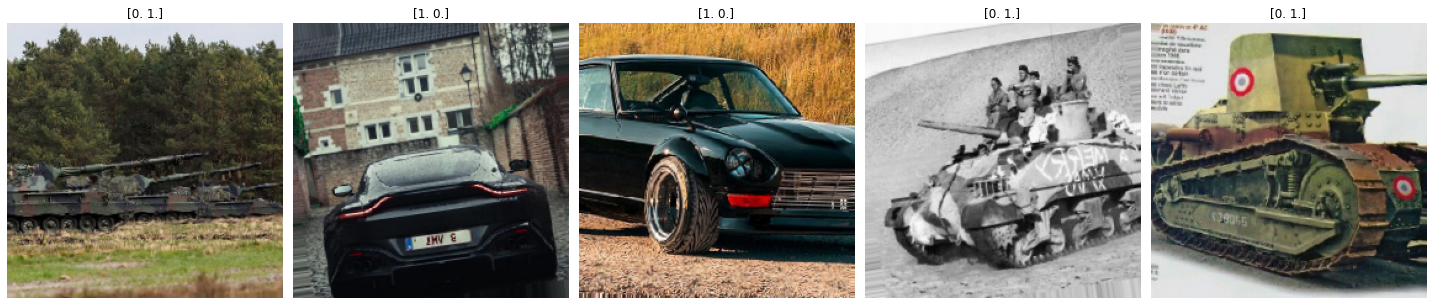

In [12]:
#step 3, plot images
plotImages(sample_training_images[:5], labels[:5])

# Model Architecture  

 
 

  

  

 
 

 
 

The architecture and saved weights of the xception network from the ImageNet contest are imported into the notebook. The weights in the network's top layers are frozen to preserve the successful pathways created during training for the ImageNet contest. The bottom 6 layers of the network are unfrozen. This allows the bottom layers to train on detection of features specific to tanks and cars. A fully connected network is added on after the unfrozen layers to generate a binary prediction from the features extracted by the convolutional layers on top. Dropout and batch normalization are added as regularization techniques to the fully connected layers in the model.   <br>   

 
 

 
 
 

  

  

 
 

## Dropout  

 
 

  

  

 
 

Dropout randomly inactivates a percentage of the connections in a layer during each step of training. This prevents the model from over developing any one pathway in the neural network. Dropout effectively creates an ensemble of weak predictors inside the model which helps generalize it for never-before-seen data. Excessive dropout will make the model fail to converge on a solution. When applied correctly, it will help keep the training and validation curves closer together.  

 
 

  

  

 
 

## Training Results 

 
 

  

  

 
 

The model achieves its best training accuracy after 4 epochs. It achieves 98% accuracy on test. This model consumes 5.1gb of system RAM, 14.3gb of GPU memory, and 24.5gb of disk space.  

 
 

  

 
 

 

In [13]:
#step 1, import xception model without classifier portion
backend.clear_session()
xception_base = Xception (weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

#step 2, select frozen layers
for layer in xception_base.layers[:-6]:
  layer.trainable = False
for layer in xception_base.layers:
  print(layer, layer.trainable)

83683744/83683744 [==============================] - 4s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f420430e7f0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f4204281e80> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f42044de0a0> False
<keras.layers.core.activation.Activation object at 0x7f42062bd160> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f4206337b80> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f42063373a0> False
<keras.layers.core.activation.Activation object at 0x7f420426ce80> False
<keras.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x7f42042d57f0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f42042d5040> False
<keras.layers.core.activation.Activation object at 0x7f42042cc460> False
<keras.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x7f42042ccbb0> False
<keras.layers.no

Epoch 1/4
53/53 [==============================] - 589s 11s/step - loss: 2.7643 - accuracy: 0.9377 - val_loss: 4.0806 - val_accuracy: 0.9731
Epoch 2/4
53/53 [==============================] - 24s 461ms/step - loss: 2.0882 - accuracy: 0.9607 - val_loss: 5.4554 - val_accuracy: 0.9692
Epoch 3/4
53/53 [==============================] - 25s 477ms/step - loss: 0.9734 - accuracy: 0.9770 - val_loss: 0.8523 - val_accuracy: 0.9885
Epoch 4/4
53/53 [==============================] - 21s 396ms/step - loss: 0.5031 - accuracy: 0.9856 - val_loss: 1.9586 - val_accuracy: 0.9769


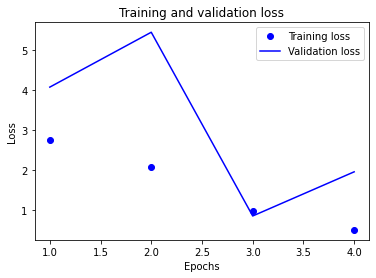

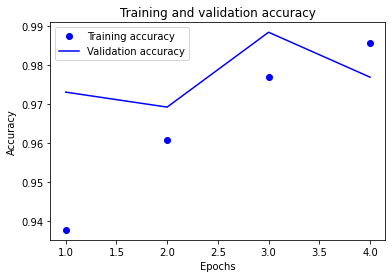

10/10 [==============================] - 129s 14s/step - loss: 0.2190 - accuracy: 0.9850
test_acc: 0.9850000143051147


In [14]:
#step 3, Create new classifier block to predict for 3 classes.
xception_train = models.Sequential()
xception_train.add(xception_base)
xception_train.add(layers.Flatten())
xception_train.add(layers.BatchNormalization())
xception_train.add(layers.Dense(1024, activation = 'relu'))
xception_train.add(layers.Dropout(0.5))
xception_train.add(layers.Dense(1024, activation = 'relu'))
xception_train.add(layers.Dropout(0.5))
xception_train.add(layers.Dense(2, activation = 'softmax'))

#step 4, compile and fit model
xception_train.compile(optimizer = optimizers.Adam(),
    loss = 'binary_crossentropy',
    metrics = 'accuracy')

# Lr scheduler removed from model to improve performance, uncomment the code to try it.
#def scheduler(epoch, lr):
#  if epoch < 10:
#    return lr
#  else:
#    return lr * tf.math.exp(-0.1)

#defining learning rate callback for use in model.fit callbacks
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

#fit model and save training history
history = xception_train.fit(
    train_generator,
    steps_per_epoch=training_step_size,
    epochs=4,
    class_weight=class_weights, 
    validation_data=validation_generator,
    validation_steps=validation_step_size,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)]) #lr_scheduler can be added to callbacks

#step 5, Generate graphs on training performance.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#step 6, test model on never before seen data
loss, acc = xception_train.evaluate(test_generator, steps = test_step_size)
print('test_acc:', acc) 

# Exporting/Importing a Saved Model

The weights of the trained model can be saved and exported to a .h5 file. This allows the model to be used for future prediction without needing to retrain it from scratch.

In [15]:
#specify google drive location to export the trained model, include file name in h5 format
xception_train.save('/content/gdrive/My Drive/cars_tanks/exception_tanks_cars.h5')

In [16]:
# import trained model from google drive location
xception_train = keras.models.load_model('/content/gdrive/My Drive/cars_tanks/exception_tanks_cars.h5')

# Breakdown of Model Results 

 
 

A confusion matrix and visualization of misclassified images will be performed to analyse the predictions made by the model. 

 
 

## Confusion Matrix 

 
 

A confusion matrix can be generated using code provided by sci-kit learn from Pedregosa et al. (2011). A confusion matrix shows a display of the ground truth labels against predictions to evaluate how accurate a machine learning model was at predicting for specific classes in the dataset. 

 

In [17]:
#plot confusion matrix
# Step 1, Import Required Libraries
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

# define the confusion matrix function, from the sklearn documentation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
     

In [18]:
#step 2, create a new, unshuffled flow_from_directory generator
confusion_test_datagen = ImageDataGenerator(rescale=1./255)

# input batch size, need variable for future calculations
batch_size_input = 20

# generate confusion generatior
confusion_test_generator = confusion_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size_input,
    class_mode='categorical',
    shuffle=False)

# create confusion step size for preditions
confusion_step_size = len(confusion_test_generator)

# create misclassified batch size to generate image with wrong predictions
misclassified_batch_size = confusion_step_size * batch_size_input

Found 200 images belonging to 2 classes.


In [19]:
#step 3, create a list of labels and predictions
test_labels = confusion_test_generator.classes
y_prob = xception_train.predict(confusion_test_generator, steps = confusion_step_size) 
preds = y_prob.argmax(axis=-1)

10/10 [==============================] - 2s 105ms/step


In [20]:
#step 4, define class names and confusion matrix 
#Define class names
class_names = ['Cars','Tanks']

#define confusion matrix object, set true labels and preds 
cm = confusion_matrix(test_labels, preds)

Confusion matrix, without normalization
[[99  1]
 [ 2 98]]


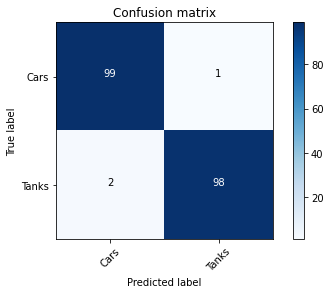

In [21]:
#step 5, plot confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix')

plt.show()

## Confusion Matrix Results 

 
 

The confusion matrix shows that the model was more likely to predict for cars than tanks. It generated 98 correct predictions out of 100 for cars and made 99 correct predictions for tanks.

 
 

## Reviewing Misclassified Images 

 
 

Misclassified images can be retrieved from the test dataset and reviewed to gain an understanding of why they may have been misclassified. This portion of code was reworked from an example by Abdulkader Helwan (2023). 

In [22]:
# step 1, create special image generator to produce sample of images for test
# resuses confusion test datagen ImageDataGenerator(w/rescaling)
misclassified_generator = confusion_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=misclassified_batch_size,
    class_mode='categorical',
    shuffle=False)

Found 200 images belonging to 2 classes.


In [23]:
# step 2, use next() to seperate pictures and labels in flow_from_directory sample
picture, true_class = next(misclassified_generator)

In [24]:
# step 3, flatten ground truth labels to a single number
truelabel=true_class.argmax(axis=1)

# flatten predictions from an array to a single number, y_prob is reused from predict() above
predlabel=y_prob.argmax(axis=1)

# step 4, select items from lists where true labels do not equal predictions
sampleimg = picture[truelabel!=predlabel]
sampletrue = truelabel[truelabel!=predlabel]
samplepred = predlabel[truelabel!=predlabel]

# show total number of misclassified images
print ('Total number of misclassified images:', sampleimg.shape[0])

#get number of images to draw
images_to_draw = sampleimg.shape[0]

Total number of misclassified images: 3


In [25]:
#step 5, define image generation function
def plot_img_results(array, true, pred, i, n=1):
    # plot the image and the target for sample i
    ncols = 3
    nrows = n/ncols + 1
    fig = plt.figure( figsize=(ncols*2, nrows*2), dpi=100)
    for j in range(n):
      index = j+i
      plt.subplot(nrows,ncols, j+1)
      plt.imshow(sampleimg[index])
      plt.title('true: {} pred: {}'.format(true[index], pred[index]))
      plt.axis('off')

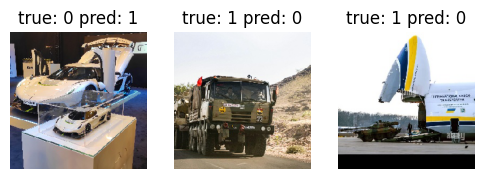

In [26]:
#use image generation function to display labels
plot_img_results(sampleimg, sampletrue, samplepred, 0, images_to_draw)

 
 

## Misclassification Discussion  

 
   

The first image may have been misclassified because of a square box in the foreground. This box may present itself as an Armour plate to the model which would be a key feature of a tank. The second misclassified image is of a truck towing a tank. This image may be better characterized as a car and the model may have generated the correct label here despite it being labeled as a tank in the dataset. The last misclassified image shows a tank coming out of the nose of an airplane. The large smooth panels of the airplane have the same texture as a car body which confused the model's prediction on this image. 

 

 
 

 
 

 
 
 

# Recommendations for Model Improvement 

 
 

The model is acheiving 98% accuracy and the images it misclassified are easy to explain. Little can be done to improve its accuracy aside from improving the image preprocessing pipeline to better center the images on the classification targets inside them.

 

# References

Abadi, A., Agarwal, P. B., Brevdo, E.,
Chen, Z., Citro, C., Corrado, G., Davis, A.,
Dean, J., Devin, M., Ghemawat, S., Goodfellow, I.,
Harp, A., Irving, G., Isard, M., Jozefowicz, R., Jia, Y., Kaiser, L., Kudlur, M., Levenberg, J., Mané, D., Schuster, M., Monga, R., Moore, S. Murray, D., Olah, C., Shlens, J., Steiner, B., Sutskever, I., Talwar, K., Tucker, P., Vanhoucke, V., Vasudevan, V., Viégas, F., Vinyals, O., Warden, P., Wattenberg, M., Wicke, M., Yu, Y., & Zheng. X., (2015). TensorFlow: Large-scale machine learning on heterogeneous systems. Software available from tensorflow.org

Chollet, Francois. (2015). Keras. GitHub. https://github.com/fchollet/keras 

Chollet, Francois. (2016). Xception: Deep Learning with Depthwise Separable Convolutions. DOI arXiv:1610.02357

deeplizard. (2020). Create A Confusion Matrix For Neural Network Predictions. retreived 02/17/2023 from https://deeplizard.com/learn/video/km7pxKy4UHU

Harris, C.R., Millman, K.J., van der Walt, S.J. et al. (2020) Array programming with NumPy. Nature 585, 357–362. DOI: 10.1038/s41586-020-2649-2

Helwan, Abdulkader. (2021).Running AI Fashion Classification on Real Data. retreived 02/17/2023 from https://www.codeproject.com/Articles/5297329/Running-AI-Fashion-Classification-on-Real-Data

Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering. https://zenodo.org/badge/DOI/10.5281/zenodo.592536.svg

Kapoor, Karnika. (2021). Pneumonia Diagnosis: Convnet Model. kaggle. retreived 02/17/2023 from https://www.kaggle.com/code/karnikakapoor/pneumonia-diagnosis-convnet-model/notebook

Pedregosa, F., Varoquaux, G., Gramfort, A., Michel, V., Thirion, B., and Grisel, O. and Blondel, M. and Prettenhofer, P., Weiss, R., Dubourg, V., Vanderplas, J., Passos, A., Cournapeau, D., Brucher, M., Perrot, M., Duchesnay, E. (2011). Scikit-learn: Machine Learning in Python. Journal of Machine Learning Research 12

r/carporn. (2023). datasource. reddit.com. retreived 01/20/2023

r/tankporn. (2023). datasource. reddit.com. retreived 01/20/2023

r/tanks. (2023). datasource. reddit.com. retreived 01/20/2023

Regis Jesuit University. (2022). MSDS660 Deep Learning Cirriculum. Regis University

Umesh, P. (2012). Image Processing in Python. CSI Communications, 23.